In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
device = '/GPU:0' if len(tf.config.list_physical_devices('GPU')) > 0 else '/CPU:0'
device

'/GPU:0'

# Load Data

In [3]:
dataset_path = 'data/training_dataset.csv'
dataset_df = pd.read_csv(dataset_path)
print("Shape:", dataset_df.shape)

Shape: (8795, 55)


In [4]:
text_df = dataset_df['Title']
features = dataset_df.columns[1:]
label_df = dataset_df[features]
num_classes = len(features)
print("Number of classes:", num_classes)

Number of classes: 54


In [5]:
train_text, val_text, train_label, val_label = train_test_split(text_df, label_df, test_size=0.2, random_state=37)
print(train_text.shape[0], "data for training")
print(val_text.shape[0], "data for validation")

7036 data for training
1759 data for validation


# Transform

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((train_text, train_label.values))
val_ds = tf.data.Dataset.from_tensor_slices((val_text, val_label.values))

In [7]:
batch_size = 128
train_ds = train_ds.shuffle(train_text.shape[0] // 4).batch(batch_size)
val_ds = val_ds.shuffle(val_text.shape[0] // 4).batch(batch_size)

# Model

## Create Model

In [10]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128/2", input_shape=[], dtype=tf.string)

In [12]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name='output')
], name='nnlm_model')

model.summary()

Model: "nnlm_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               112461824 
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 54)                6966      
Total params: 112,468,790
Trainable params: 6,966
Non-trainable params: 112,461,824
_________________________________________________________________


In [13]:
# compile model
optimizer = tf.keras.optimizers.Adam(3e-5)
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)

## Training

In [14]:
# reduce learning rate and save model
saved_model_path = 'nnlm_kaidah_model.h5'
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(), 
             tf.keras.callbacks.ModelCheckpoint(saved_model_path, save_best_only=True)]

In [15]:
num_epoch = 300
history = model.fit(train_ds, 
                    epochs=num_epoch, 
                    batch_size=batch_size, 
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/300
55/55 [==============================] - 2s 14ms/step - loss: 0.7046 - accuracy: 0.0082 - auc: 0.3307 - val_loss: 0.7007 - val_accuracy: 0.0091 - val_auc: 0.3430
Epoch 2/300
55/55 [==============================] - 1s 10ms/step - loss: 0.6968 - accuracy: 0.0082 - auc: 0.3601 - val_loss: 0.6930 - val_accuracy: 0.0097 - val_auc: 0.3747
Epoch 3/300
55/55 [==============================] - 1s 9ms/step - loss: 0.6891 - accuracy: 0.0084 - auc: 0.3935 - val_loss: 0.6854 - val_accuracy: 0.0102 - val_auc: 0.4096
Epoch 4/300
55/55 [==============================] - 1s 9ms/step - loss: 0.6815 - accuracy: 0.0088 - auc: 0.4297 - val_loss: 0.6779 - val_accuracy: 0.0102 - val_auc: 0.4478
Epoch 5/300
55/55 [==============================] - 1s 9ms/step - loss: 0.6740 - accuracy: 0.0095 - auc: 0.4686 - val_loss: 0.6705 - val_accuracy: 0.0102 - val_auc: 0.4869
Epoch 6/300
55/55 [==============================] - 1s 10ms/step - loss: 0.6666 - accuracy: 0.0107 - auc: 0.5083 - val_loss: 0.6631 

Epoch 48/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4277 - accuracy: 0.5146 - auc: 0.7914 - val_loss: 0.4265 - val_accuracy: 0.4986 - val_auc: 0.7902
Epoch 49/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4234 - accuracy: 0.5152 - auc: 0.7915 - val_loss: 0.4222 - val_accuracy: 0.4991 - val_auc: 0.7900
Epoch 50/300
55/55 [==============================] - 1s 9ms/step - loss: 0.4191 - accuracy: 0.5153 - auc: 0.7912 - val_loss: 0.4180 - val_accuracy: 0.4991 - val_auc: 0.7901
Epoch 51/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4149 - accuracy: 0.5161 - auc: 0.7913 - val_loss: 0.4138 - val_accuracy: 0.4991 - val_auc: 0.7900
Epoch 52/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4108 - accuracy: 0.5162 - auc: 0.7910 - val_loss: 0.4097 - val_accuracy: 0.4991 - val_auc: 0.7900
Epoch 53/300
55/55 [==============================] - 1s 10ms/step - loss: 0.4067 - accuracy: 0.5162 - auc: 0.7911 - val_loss:

Epoch 95/300
55/55 [==============================] - 1s 9ms/step - loss: 0.2724 - accuracy: 0.5176 - auc: 0.7930 - val_loss: 0.2724 - val_accuracy: 0.5003 - val_auc: 0.7932
Epoch 96/300
55/55 [==============================] - 1s 10ms/step - loss: 0.2700 - accuracy: 0.5176 - auc: 0.7931 - val_loss: 0.2699 - val_accuracy: 0.5003 - val_auc: 0.7932
Epoch 97/300
55/55 [==============================] - 1s 10ms/step - loss: 0.2676 - accuracy: 0.5176 - auc: 0.7932 - val_loss: 0.2675 - val_accuracy: 0.5003 - val_auc: 0.7933
Epoch 98/300
55/55 [==============================] - 1s 10ms/step - loss: 0.2652 - accuracy: 0.5178 - auc: 0.7933 - val_loss: 0.2652 - val_accuracy: 0.5003 - val_auc: 0.7935
Epoch 99/300
55/55 [==============================] - 1s 10ms/step - loss: 0.2628 - accuracy: 0.5178 - auc: 0.7934 - val_loss: 0.2628 - val_accuracy: 0.5003 - val_auc: 0.7937
Epoch 100/300
55/55 [==============================] - 1s 10ms/step - loss: 0.2604 - accuracy: 0.5178 - auc: 0.7936 - val_loss

55/55 [==============================] - 1s 9ms/step - loss: 0.1847 - accuracy: 0.5178 - auc: 0.8013 - val_loss: 0.1852 - val_accuracy: 0.5003 - val_auc: 0.8011
Epoch 142/300
55/55 [==============================] - 1s 9ms/step - loss: 0.1833 - accuracy: 0.5178 - auc: 0.8015 - val_loss: 0.1838 - val_accuracy: 0.5003 - val_auc: 0.8015
Epoch 143/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1819 - accuracy: 0.5178 - auc: 0.8016 - val_loss: 0.1824 - val_accuracy: 0.5003 - val_auc: 0.8017
Epoch 144/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1805 - accuracy: 0.5178 - auc: 0.8019 - val_loss: 0.1810 - val_accuracy: 0.5003 - val_auc: 0.8017
Epoch 145/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1791 - accuracy: 0.5178 - auc: 0.8021 - val_loss: 0.1796 - val_accuracy: 0.5003 - val_auc: 0.8018
Epoch 146/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1778 - accuracy: 0.5178 - auc: 0.8023 - val_loss: 0.1782 -

Epoch 188/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1329 - accuracy: 0.5179 - auc: 0.8143 - val_loss: 0.1336 - val_accuracy: 0.5003 - val_auc: 0.8130
Epoch 189/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1321 - accuracy: 0.5179 - auc: 0.8147 - val_loss: 0.1328 - val_accuracy: 0.5003 - val_auc: 0.8133
Epoch 190/300
55/55 [==============================] - 1s 9ms/step - loss: 0.1313 - accuracy: 0.5179 - auc: 0.8150 - val_loss: 0.1320 - val_accuracy: 0.5003 - val_auc: 0.8136
Epoch 191/300
55/55 [==============================] - 1s 9ms/step - loss: 0.1305 - accuracy: 0.5179 - auc: 0.8153 - val_loss: 0.1312 - val_accuracy: 0.5003 - val_auc: 0.8137
Epoch 192/300
55/55 [==============================] - 1s 9ms/step - loss: 0.1297 - accuracy: 0.5179 - auc: 0.8155 - val_loss: 0.1304 - val_accuracy: 0.5003 - val_auc: 0.8141
Epoch 193/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1289 - accuracy: 0.5179 - auc: 0.8159 - val_l

55/55 [==============================] - 1s 10ms/step - loss: 0.1037 - accuracy: 0.5179 - auc: 0.8297 - val_loss: 0.1045 - val_accuracy: 0.5003 - val_auc: 0.8263
Epoch 235/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1033 - accuracy: 0.5179 - auc: 0.8301 - val_loss: 0.1041 - val_accuracy: 0.5003 - val_auc: 0.8268
Epoch 236/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1028 - accuracy: 0.5179 - auc: 0.8303 - val_loss: 0.1036 - val_accuracy: 0.5003 - val_auc: 0.8271
Epoch 237/300
55/55 [==============================] - 1s 11ms/step - loss: 0.1023 - accuracy: 0.5179 - auc: 0.8307 - val_loss: 0.1031 - val_accuracy: 0.5003 - val_auc: 0.8274
Epoch 238/300
55/55 [==============================] - 1s 10ms/step - loss: 0.1019 - accuracy: 0.5179 - auc: 0.8310 - val_loss: 0.1027 - val_accuracy: 0.5003 - val_auc: 0.8278
Epoch 239/300
55/55 [==============================] - 1s 9ms/step - loss: 0.1014 - accuracy: 0.5179 - auc: 0.8313 - val_loss: 0.1022 

Epoch 281/300
55/55 [==============================] - 1s 10ms/step - loss: 0.0865 - accuracy: 0.5179 - auc: 0.8463 - val_loss: 0.0874 - val_accuracy: 0.5003 - val_auc: 0.8412
Epoch 282/300
55/55 [==============================] - 1s 10ms/step - loss: 0.0862 - accuracy: 0.5179 - auc: 0.8468 - val_loss: 0.0872 - val_accuracy: 0.5003 - val_auc: 0.8416
Epoch 283/300
55/55 [==============================] - 1s 10ms/step - loss: 0.0859 - accuracy: 0.5179 - auc: 0.8471 - val_loss: 0.0869 - val_accuracy: 0.5003 - val_auc: 0.8417
Epoch 284/300
55/55 [==============================] - 1s 10ms/step - loss: 0.0857 - accuracy: 0.5179 - auc: 0.8476 - val_loss: 0.0866 - val_accuracy: 0.5003 - val_auc: 0.8422
Epoch 285/300
55/55 [==============================] - 1s 11ms/step - loss: 0.0854 - accuracy: 0.5179 - auc: 0.8479 - val_loss: 0.0864 - val_accuracy: 0.5003 - val_auc: 0.8424
Epoch 286/300
55/55 [==============================] - 1s 9ms/step - loss: 0.0851 - accuracy: 0.5179 - auc: 0.8482 - val

## Plot Metric

In [16]:
directory = 'metric/'
if not os.path.exists(directory):
    os.mkdir(directory)

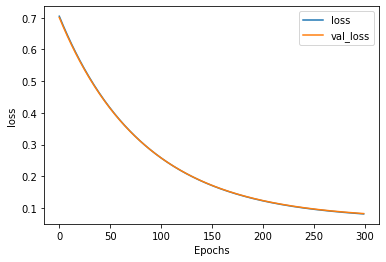

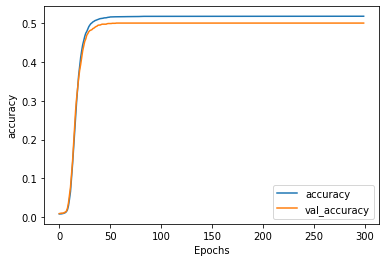

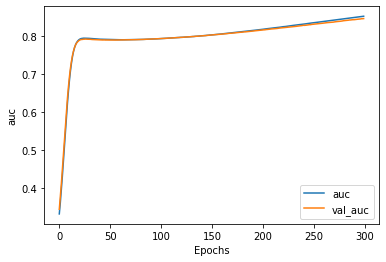

In [17]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.savefig(directory+'nnlm_'+string+'.png')
    plt.show()

for metric in model.metrics_names:
    plot_graphs(history, metric)